# Comparing Plasticity Rules

## For every model, meta-learn on 8-dimensional halfspace dataset, then transfer rules to a NEW instance, and train / test that on the same dataset type but with fixed rules.

Written by Basile Van Hoorick & Brett Karopczyc, Fall 2020.

In [1]:
%run FF_common.ipynb

In [2]:
# IMPORTANT: Henceforth, we use GD directly on inputs but use plasticity rules in the output and hidden layers.
opts_up = Options(gd_input=True,
                  use_graph_rule=True,
                  gd_graph_rule=True,
                  use_output_rule=True,
                  gd_output_rule=True,
                  gd_output=False)
opts_down = Options(gd_input=True,
                    use_graph_rule=True,
                    gd_graph_rule=False,  # Not meta-trainable anymore!
                    use_output_rule=True,
                    gd_output_rule=False,  # Not meta-trainable anymore!
                    gd_output=False)

scheme = UpdateScheme(cross_entropy_loss=True,
                      mse_loss=False,
                      update_misclassified_only=False,
                      update_all_edges=True)

# Feed-forward brain config.
n_up = 8  # Input layer size for meta-learning.
n_down = 8  # Input layer size for desired task training.
m = 2  # Output layer size.
l = 2  # Number of hidden layers.
w = 32  # Width of hidden layers.
p = 0.5  # Connectivity probability.
cap = 16  # Number of nodes firing per layer.

# Training config.
num_runs = 5
num_rule_epochs = 50
num_epochs_upstream = 1
num_epochs_downstream = 3
downstream_backprop = True
dataset_up = 'halfspace'
dataset_down = dataset_up

In [3]:
# Prepare to gather stats for our experiments
stats = {}

## Evaluate a Feed-Forward network trained with Gradient Descent as a baseline

In [4]:
gd_net = FFBrainNet(n_down, m, l, w, p, cap, full_gd=True)
X_train, y_train, X_test, y_test = quick_get_data(dataset_down, n_down)
stats_down = train_downstream(
            X_train, y_train, gd_net, num_epochs=num_epochs_downstream,
            batch_size=100, vanilla=True, learn_rate=1e-2,
            X_test=X_test, y_test=y_test, verbose=False,
            stats_interval=300, disable_backprop=False)
stats['GD'] = (None, stats_down)

 40%|████      | 6/15 [00:00<00:00, 59.38it/s]

INITIAL train accuracy: 0.5187
INITIAL test accuracy: 0.5140
Epoch 1 / 3 ...


100%|██████████| 15/15 [00:00<00:00, 74.85it/s]


Epoch 2 / 3 ...



100%|██████████| 15/15 [00:00<00:00, 75.64it/s]



Epoch 3 / 3 ...

Last loss: 0.4420
Last train accuracy: 0.9300
Last test accuracy: 0.9320


## Evaluate an RNN network using the form of plasticity rule in the paper

In [5]:
# Instantiate upstream and downstream network factories
net_up_fact = lambda: LocalNet(n_up, m, w, p, cap, 1, options=opts_up, update_scheme=scheme)
net_down_fact = lambda: LocalNet(n_down, m, w, p, cap, 1, options=opts_down, update_scheme=scheme)

In [6]:
# Evaluate model.
print('==== Original RNN (very different from all the rest) ====')
stats_up, stats_down = evaluate_up_down(
    net_up_fact, net_down_fact, n_up, n_down,
    dataset_up=dataset_up, dataset_down=dataset_down,
    downstream_backprop=downstream_backprop, num_runs=num_runs, num_rule_epochs=num_rule_epochs,
    num_epochs_upstream=num_epochs_upstream, num_epochs_downstream=num_epochs_downstream)

agg_stats_up = convert_multi_stats_uncertainty(stats_up)
agg_stats_down = convert_multi_stats_uncertainty(stats_down)

stats['RNN'] = (agg_stats_up, agg_stats_down)

  0%|          | 0/50 [00:00<?, ?it/s]

==== Original RNN (very different from all the rest) ====

Run 1 / 5...
Meta-learning on halfspace...


100%|██████████| 50/50 [00:48<00:00,  1.04it/s]
../LocalNetBase.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.rnn_rule = torch.tensor(rule).flatten().double()
  5%|▌         | 79/1500 [00:00<00:01, 781.95it/s]

Last loss: 0.3431
Last train accuracy: 0.9793
Last test accuracy: 0.9740
Training accuracy history:
[0.5833 0.586  0.58   0.6233 0.672  0.7967 0.8013 0.866  0.892  0.9407
 0.9327 0.948  0.908  0.9293 0.9273 0.948  0.9567 0.9547 0.94   0.958
 0.9687 0.964  0.9687 0.972  0.9753 0.9773 0.9627 0.9433 0.9613 0.9813
 0.9633 0.9733 0.9753 0.9673 0.978  0.974  0.982  0.974  0.958  0.984
 0.9713 0.9707 0.9833 0.974  0.9693 0.978  0.978  0.972  0.9833 0.9793]
Training NEW brain instance on halfspace...
INITIAL train accuracy: 0.6020
INITIAL test accuracy: 0.6100
Epoch 1 / 3 ...


  6%|▋         | 94/1500 [00:00<00:01, 936.82it/s]


Epoch 2 / 3 ...


 13%|█▎        | 188/1500 [00:00<00:01, 924.92it/s]


Epoch 3 / 3 ...


  0%|          | 0/50 [00:00<?, ?it/s]


Last loss: 0.3799
Last train accuracy: 0.9300
Last test accuracy: 0.9360


Run 2 / 5...
Meta-learning on halfspace...


  5%|▌         | 77/1500 [00:00<00:01, 768.19it/s]

Last loss: 0.3406
Last train accuracy: 0.9880
Last test accuracy: 0.9820
Training accuracy history:
[0.5933 0.7    0.7747 0.756  0.8327 0.8947 0.9247 0.9447 0.9467 0.9513
 0.948  0.968  0.9593 0.9733 0.974  0.9793 0.976  0.9513 0.99   0.9733
 0.976  0.9633 0.984  0.9773 0.962  0.9687 0.984  0.9793 0.9793 0.964
 0.9807 0.9793 0.9673 0.974  0.98   0.986  0.974  0.9833 0.9913 0.9893
 0.956  0.9813 0.986  0.994  0.9907 0.9827 0.9747 0.9853 0.9833 0.988 ]
Training NEW brain instance on halfspace...
INITIAL train accuracy: 0.5953
INITIAL test accuracy: 0.6580
Epoch 1 / 3 ...


 12%|█▏        | 183/1500 [00:00<00:01, 909.26it/s]


Epoch 2 / 3 ...


  6%|▌         | 93/1500 [00:00<00:01, 922.87it/s]


Epoch 3 / 3 ...


  0%|          | 0/50 [00:00<?, ?it/s]


Last loss: 0.4433
Last train accuracy: 0.8993
Last test accuracy: 0.8620


Run 3 / 5...
Meta-learning on halfspace...


  5%|▌         | 82/1500 [00:00<00:01, 810.71it/s]

Last loss: 0.3408
Last train accuracy: 0.9827
Last test accuracy: 0.9680
Training accuracy history:
[0.5633 0.592  0.6767 0.7027 0.8253 0.9267 0.942  0.954  0.926  0.9573
 0.9567 0.948  0.9587 0.9567 0.9693 0.968  0.9793 0.982  0.9827 0.9733
 0.9807 0.9573 0.9747 0.9793 0.9727 0.9827 0.9813 0.9873 0.9753 0.972
 0.9753 0.9867 0.9833 0.9753 0.9793 0.9727 0.9867 0.9767 0.9767 0.9527
 0.986  0.97   0.982  0.984  0.97   0.986  0.9793 0.9867 0.9687 0.9827]
Training NEW brain instance on halfspace...
INITIAL train accuracy: 0.6787
INITIAL test accuracy: 0.6900
Epoch 1 / 3 ...


  6%|▌         | 87/1500 [00:00<00:01, 859.31it/s]


Epoch 2 / 3 ...


  6%|▋         | 94/1500 [00:00<00:01, 933.65it/s]


Epoch 3 / 3 ...


  0%|          | 0/50 [00:00<?, ?it/s]


Last loss: 0.4166
Last train accuracy: 0.9033
Last test accuracy: 0.9040


Run 4 / 5...
Meta-learning on halfspace...


  5%|▌         | 81/1500 [00:00<00:01, 807.80it/s]

Last loss: 0.3500
Last train accuracy: 0.9800
Last test accuracy: 0.9780
Training accuracy history:
[0.7653 0.642  0.7153 0.822  0.8347 0.8793 0.9307 0.9167 0.934  0.9453
 0.9113 0.9367 0.9507 0.948  0.9507 0.9373 0.9553 0.9707 0.9733 0.9707
 0.974  0.974  0.978  0.9793 0.9833 0.9767 0.9533 0.974  0.972  0.9693
 0.982  0.976  0.9847 0.9827 0.986  0.9573 0.978  0.9627 0.9813 0.9633
 0.958  0.986  0.9807 0.9787 0.9547 0.9833 0.978  0.9747 0.9807 0.98  ]
Training NEW brain instance on halfspace...
INITIAL train accuracy: 0.3220
INITIAL test accuracy: 0.3120
Epoch 1 / 3 ...


 13%|█▎        | 191/1500 [00:00<00:01, 939.13it/s]


Epoch 2 / 3 ...


  6%|▋         | 94/1500 [00:00<00:01, 935.17it/s]


Epoch 3 / 3 ...


  0%|          | 0/50 [00:00<?, ?it/s]


Last loss: 0.4599
Last train accuracy: 0.8627
Last test accuracy: 0.8360


Run 5 / 5...
Meta-learning on halfspace...


  6%|▌         | 83/1500 [00:00<00:01, 824.62it/s]

Last loss: 0.3442
Last train accuracy: 0.9860
Last test accuracy: 0.9820
Training accuracy history:
[0.636  0.7993 0.7693 0.8807 0.8713 0.9207 0.922  0.922  0.924  0.944
 0.928  0.9433 0.9493 0.9587 0.962  0.9587 0.9627 0.972  0.972  0.9847
 0.978  0.9847 0.9747 0.9833 0.9673 0.9827 0.976  0.988  0.9793 0.9833
 0.9787 0.9813 0.9827 0.9853 0.9927 0.9827 0.9793 0.978  0.988  0.9833
 0.9753 0.9613 0.97   0.9847 0.9847 0.9907 0.984  0.9893 0.982  0.986 ]
Training NEW brain instance on halfspace...
INITIAL train accuracy: 0.6240
INITIAL test accuracy: 0.6220
Epoch 1 / 3 ...


  6%|▋         | 97/1500 [00:00<00:01, 966.18it/s]


Epoch 2 / 3 ...


  4%|▍         | 67/1500 [00:00<00:02, 662.04it/s]


Epoch 3 / 3 ...


100%|██████████| 1500/1500 [00:02<00:00, 740.31it/s]


Last loss: 0.4166
Last train accuracy: 0.8880
Last test accuracy: 0.9140



## Evaluate Feed-Forward networks with all forms of plasticity rules

In [7]:
rules = {'PrePost': {'class':TableRule_PrePost, 'desc':"Table | Pre and Post"},
         'PrePostCount': {'class':TableRule_PrePostCount, 'desc':"Table | Pre, Post, and Incoming Count"},
         'PrePostPercent': {'class':TableRule_PrePostPercent, 'desc':"Table | Pre, Post and Binned Incoming Fraction"},
         'PostCount': {'class':TableRule_PostCount, 'desc':"Table | Post and Incoming Count", 'min_acc':0.4},
         'ANNPrePost': {'class':OneBetaANNRule_PrePost, 'desc':"One Beta ANN | Pre and Post"},
         'ANNPrePostAll': {'class':OneBetaANNRule_PrePostAll, 'desc':"One Beta ANN | Pre, Post, and All Incoming"},
         'ANNOnePostAll': {'class':OneBetaANNRule_PostAll, 'desc':"One Beta ANN | Post and All Incoming", 'min_acc':0.4},
         'ANNAllPostAll': {'class':AllBetasANNRule_PostAll, 'desc':"All Betas ANN | Post and All Incoming"}}

In [8]:
# For each form of plasticity rule we want to try...
for tag, rule_dict in rules.items():
    
    rule_class = rule_dict['class']
    description = rule_dict['desc']
    min_acc = rule_dict.get('min_acc', 0.7)
    
    # Instantiate upstream and downstream network factories
    net_up_fact = lambda: FFLocalNet(
        n_up, m, l, w, p, cap,
        hl_rules=rule_class() if opts_up.use_graph_rule else None,
        output_rule=rule_class() if opts_up.use_output_rule else None,
        options=opts_up, update_scheme=scheme)
    
    net_down_fact = lambda: FFLocalNet(
        n_down, m, l, w, p, cap,
        hl_rules=rule_class() if opts_down.use_graph_rule else None,
        output_rule=rule_class() if opts_down.use_output_rule else None,
        options=opts_down, update_scheme=scheme)
    
    # Evaluate the model
    print(f'==== Interpretation: {description} ====')
    stats_up, stats_down = evaluate_up_down(
        net_up_fact, net_down_fact, n_up, n_down,
        dataset_up=dataset_up, dataset_down=dataset_down,
        downstream_backprop=downstream_backprop, num_runs=num_runs, num_rule_epochs=num_rule_epochs,
        num_epochs_upstream=num_epochs_upstream, num_epochs_downstream=num_epochs_downstream,
        min_upstream_acc=min_acc)

    # Store the learning stats
    agg_stats_up = convert_multi_stats_uncertainty(stats_up)
    agg_stats_down = convert_multi_stats_uncertainty(stats_down)

    stats[tag] = (agg_stats_up, agg_stats_down)

  0%|          | 0/50 [00:00<?, ?it/s]

==== Interpretation: Table | Pre and Post ====

Run 1 / 5...
Meta-learning on halfspace...


  6%|▋         | 96/1500 [00:00<00:01, 952.30it/s]

Last loss: 0.3492
Last train accuracy: 0.9767
Last test accuracy: 0.9660
Training accuracy history:
[0.6347 0.6793 0.7067 0.8093 0.7933 0.8793 0.8967 0.8933 0.9193 0.9267
 0.9187 0.94   0.9433 0.9393 0.936  0.952  0.954  0.9673 0.9653 0.974
 0.962  0.978  0.9733 0.9727 0.9667 0.9673 0.9687 0.97   0.982  0.9727
 0.9753 0.9827 0.9773 0.9753 0.968  0.966  0.9713 0.9747 0.976  0.972
 0.9733 0.9753 0.972  0.9773 0.976  0.968  0.9767 0.9713 0.9767 0.9767]
Training NEW brain instance on halfspace...
INITIAL train accuracy: 0.5020
INITIAL test accuracy: 0.4920
Epoch 1 / 3 ...


  7%|▋         | 110/1500 [00:00<00:01, 1092.45it/s]


Epoch 2 / 3 ...


 14%|█▍        | 216/1500 [00:00<00:01, 1050.55it/s]


Epoch 3 / 3 ...


  0%|          | 0/50 [00:00<?, ?it/s]


Last loss: 0.4933
Last train accuracy: 0.8193
Last test accuracy: 0.8300


Run 2 / 5...
Meta-learning on halfspace...


  6%|▋         | 95/1500 [00:00<00:01, 940.54it/s]

Last loss: 0.3533
Last train accuracy: 0.9693
Last test accuracy: 0.9420
Training accuracy history:
[0.726  0.7613 0.7453 0.7653 0.81   0.8173 0.7927 0.8387 0.798  0.8547
 0.92   0.888  0.9267 0.9427 0.94   0.9387 0.9307 0.9533 0.9367 0.96
 0.958  0.9653 0.9587 0.9653 0.9707 0.9573 0.9653 0.942  0.968  0.9627
 0.9687 0.9713 0.9687 0.97   0.9633 0.9667 0.9587 0.9673 0.9673 0.976
 0.9673 0.9713 0.9473 0.972  0.9653 0.958  0.9713 0.9787 0.9733 0.9693]
Training NEW brain instance on halfspace...
INITIAL train accuracy: 0.4647
INITIAL test accuracy: 0.5040
Epoch 1 / 3 ...


  5%|▍         | 71/1500 [00:00<00:02, 708.92it/s]


Epoch 2 / 3 ...


  7%|▋         | 102/1500 [00:00<00:01, 1017.01it/s]


Epoch 3 / 3 ...


  0%|          | 0/50 [00:00<?, ?it/s]


Last loss: 0.4699
Last train accuracy: 0.8540
Last test accuracy: 0.8600


Run 3 / 5...
Meta-learning on halfspace...


  7%|▋         | 98/1500 [00:00<00:01, 974.84it/s]

Last loss: 0.3487
Last train accuracy: 0.9733
Last test accuracy: 0.9600
Training accuracy history:
[0.8347 0.8447 0.8527 0.8767 0.882  0.8827 0.9    0.8987 0.9127 0.9307
 0.9353 0.9347 0.9373 0.9413 0.9487 0.948  0.936  0.952  0.9547 0.9647
 0.9687 0.9667 0.9687 0.9713 0.9733 0.97   0.976  0.9633 0.9647 0.9627
 0.9767 0.9693 0.9813 0.9707 0.9667 0.9767 0.966  0.9873 0.9373 0.972
 0.9727 0.9767 0.9853 0.976  0.984  0.9753 0.974  0.98   0.966  0.9733]
Training NEW brain instance on halfspace...
INITIAL train accuracy: 0.4913
INITIAL test accuracy: 0.4960
Epoch 1 / 3 ...


 14%|█▍        | 208/1500 [00:00<00:01, 1042.78it/s]


Epoch 2 / 3 ...


  7%|▋         | 109/1500 [00:00<00:01, 1083.64it/s]


Epoch 3 / 3 ...


  0%|          | 0/50 [00:00<?, ?it/s]


Last loss: 0.4233
Last train accuracy: 0.8853
Last test accuracy: 0.8660


Run 4 / 5...
Meta-learning on halfspace...


  6%|▋         | 97/1500 [00:00<00:01, 969.36it/s]

Last loss: 0.3526
Last train accuracy: 0.9667
Last test accuracy: 0.9380
Training accuracy history:
[0.6433 0.7027 0.7827 0.8093 0.8133 0.8213 0.8567 0.8467 0.862  0.882
 0.908  0.8913 0.9073 0.924  0.9107 0.9307 0.9453 0.948  0.9573 0.9513
 0.9413 0.9667 0.9573 0.958  0.9693 0.964  0.9647 0.9593 0.964  0.9687
 0.9613 0.9707 0.946  0.9713 0.9653 0.9633 0.9653 0.9613 0.9687 0.976
 0.968  0.9693 0.9653 0.976  0.974  0.9713 0.968  0.9673 0.97   0.9667]
Training NEW brain instance on halfspace...
INITIAL train accuracy: 0.5240
INITIAL test accuracy: 0.4880
Epoch 1 / 3 ...


 14%|█▍        | 208/1500 [00:00<00:01, 1016.95it/s]


Epoch 2 / 3 ...


  7%|▋         | 110/1500 [00:00<00:01, 1093.28it/s]


Epoch 3 / 3 ...


  0%|          | 0/50 [00:00<?, ?it/s]


Last loss: 0.5566
Last train accuracy: 0.7893
Last test accuracy: 0.7820


Run 5 / 5...
Meta-learning on halfspace...


  6%|▋         | 96/1500 [00:00<00:01, 952.46it/s]

Last loss: 0.3518
Last train accuracy: 0.9753
Last test accuracy: 0.9660
Training accuracy history:
[0.7507 0.7833 0.7987 0.7973 0.8367 0.8453 0.8847 0.8767 0.9053 0.9193
 0.9147 0.9233 0.938  0.95   0.944  0.9447 0.9593 0.9613 0.9513 0.966
 0.9747 0.954  0.9607 0.96   0.9733 0.9767 0.9753 0.9733 0.96   0.976
 0.9693 0.9633 0.9687 0.9673 0.974  0.9753 0.9567 0.9787 0.968  0.962
 0.9747 0.9733 0.956  0.974  0.968  0.9693 0.9653 0.974  0.9633 0.9753]
Training NEW brain instance on halfspace...
INITIAL train accuracy: 0.4947
INITIAL test accuracy: 0.5220
Epoch 1 / 3 ...


  5%|▌         | 82/1500 [00:00<00:01, 814.46it/s]


Epoch 2 / 3 ...


 13%|█▎        | 191/1500 [00:00<00:01, 928.79it/s]


Epoch 3 / 3 ...


  0%|          | 0/50 [00:00<?, ?it/s]


Last loss: 0.5099
Last train accuracy: 0.8207
Last test accuracy: 0.8280

==== Interpretation: Table | Pre, Post, and Incoming Count ====

Run 1 / 5...
Meta-learning on halfspace...


  6%|▌         | 86/1500 [00:00<00:01, 853.61it/s]

Last loss: 0.3589
Last train accuracy: 0.9740
Last test accuracy: 0.9700
Training accuracy history:
[0.686  0.73   0.75   0.7487 0.7873 0.8287 0.8713 0.864  0.8673 0.896
 0.924  0.9293 0.9413 0.936  0.9493 0.9373 0.9587 0.9493 0.9447 0.9493
 0.9693 0.9747 0.9673 0.948  0.9747 0.9613 0.968  0.9633 0.9707 0.972
 0.966  0.9793 0.9713 0.9687 0.96   0.9767 0.9807 0.9773 0.9747 0.9773
 0.9707 0.954  0.972  0.97   0.9667 0.9667 0.958  0.9787 0.9787 0.974 ]
Training NEW brain instance on halfspace...
INITIAL train accuracy: 0.5067
INITIAL test accuracy: 0.5060
Epoch 1 / 3 ...


  7%|▋         | 101/1500 [00:00<00:01, 1001.61it/s]


Epoch 2 / 3 ...


  6%|▌         | 93/1500 [00:00<00:01, 924.96it/s]


Epoch 3 / 3 ...


  0%|          | 0/50 [00:00<?, ?it/s]


Last loss: 0.4833
Last train accuracy: 0.8473
Last test accuracy: 0.8540


Run 2 / 5...
Meta-learning on halfspace...


  6%|▌         | 93/1500 [00:00<00:01, 925.35it/s]

Last loss: 0.3664
Last train accuracy: 0.9793
Last test accuracy: 0.9700
Training accuracy history:
[0.824  0.816  0.8253 0.8493 0.8847 0.9007 0.9287 0.9247 0.93   0.928
 0.954  0.968  0.9547 0.9587 0.9567 0.9707 0.966  0.9713 0.9627 0.9707
 0.9767 0.9753 0.9647 0.9687 0.9727 0.9747 0.974  0.9713 0.9633 0.9707
 0.9667 0.968  0.978  0.9727 0.9667 0.9753 0.9627 0.9687 0.9687 0.98
 0.9667 0.9567 0.9713 0.9707 0.95   0.964  0.97   0.9653 0.9773 0.9793]
Training NEW brain instance on halfspace...
INITIAL train accuracy: 0.4873
INITIAL test accuracy: 0.4900
Epoch 1 / 3 ...


  7%|▋         | 100/1500 [00:00<00:01, 999.74it/s]


Epoch 2 / 3 ...


 14%|█▎        | 206/1500 [00:00<00:01, 1025.29it/s]


Epoch 3 / 3 ...


  0%|          | 0/50 [00:00<?, ?it/s]


Last loss: 0.5166
Last train accuracy: 0.7953
Last test accuracy: 0.8300


Run 3 / 5...
Meta-learning on halfspace...


  6%|▌         | 90/1500 [00:00<00:01, 895.92it/s]

Last loss: 0.3616
Last train accuracy: 0.9667
Last test accuracy: 0.9560
Training accuracy history:
[0.7033 0.7467 0.7527 0.838  0.808  0.8547 0.8987 0.9    0.8973 0.9093
 0.9233 0.9387 0.9427 0.952  0.9487 0.9473 0.956  0.9593 0.9647 0.964
 0.968  0.9747 0.9673 0.9633 0.9693 0.9633 0.9693 0.97   0.966  0.9667
 0.9787 0.964  0.966  0.9713 0.958  0.9653 0.962  0.9627 0.9553 0.9747
 0.968  0.9707 0.966  0.9433 0.976  0.9707 0.9667 0.9673 0.9693 0.9667]
Training NEW brain instance on halfspace...
INITIAL train accuracy: 0.5027
INITIAL test accuracy: 0.4860
Epoch 1 / 3 ...


  3%|▎         | 52/1500 [00:00<00:02, 517.98it/s]


Epoch 2 / 3 ...


  5%|▌         | 81/1500 [00:00<00:01, 801.81it/s]


Epoch 3 / 3 ...


  0%|          | 0/50 [00:00<?, ?it/s]


Last loss: 0.5166
Last train accuracy: 0.8293
Last test accuracy: 0.8500


Run 4 / 5...
Meta-learning on halfspace...


  4%|▍         | 65/1500 [00:00<00:02, 647.18it/s]

Last loss: 0.3711
Last train accuracy: 0.9313
Last test accuracy: 0.9380
Training accuracy history:
[0.796  0.8253 0.7507 0.8073 0.8213 0.8753 0.8453 0.898  0.8833 0.9033
 0.9227 0.9253 0.9453 0.9307 0.9527 0.9387 0.9547 0.958  0.93   0.954
 0.9667 0.9507 0.962  0.9553 0.978  0.9553 0.9733 0.9567 0.96   0.9653
 0.922  0.9787 0.962  0.958  0.9733 0.9687 0.968  0.9713 0.9673 0.972
 0.964  0.9773 0.974  0.9707 0.968  0.9773 0.968  0.9653 0.914  0.9313]
Training NEW brain instance on halfspace...
INITIAL train accuracy: 0.4773
INITIAL test accuracy: 0.4800
Epoch 1 / 3 ...


 12%|█▏        | 181/1500 [00:00<00:01, 895.84it/s]


Epoch 2 / 3 ...


  7%|▋         | 99/1500 [00:00<00:01, 987.60it/s]


Epoch 3 / 3 ...


  0%|          | 0/50 [00:00<?, ?it/s]


Last loss: 0.4698
Last train accuracy: 0.8333
Last test accuracy: 0.8020


Run 5 / 5...
Meta-learning on halfspace...


  6%|▌         | 87/1500 [00:00<00:01, 861.44it/s]

Last loss: 0.3656
Last train accuracy: 0.9620
Last test accuracy: 0.9400
Training accuracy history:
[0.7053 0.7407 0.7973 0.7933 0.7987 0.8493 0.8627 0.878  0.87   0.8993
 0.9347 0.9447 0.9407 0.9167 0.94   0.9507 0.91   0.9753 0.9293 0.968
 0.9487 0.9707 0.9673 0.9647 0.9647 0.9133 0.974  0.97   0.972  0.9673
 0.9507 0.958  0.9733 0.9753 0.954  0.98   0.9627 0.9387 0.9713 0.9513
 0.972  0.952  0.9647 0.972  0.9593 0.9533 0.9733 0.9767 0.966  0.962 ]
Training NEW brain instance on halfspace...
INITIAL train accuracy: 0.5067
INITIAL test accuracy: 0.4720
Epoch 1 / 3 ...


  5%|▌         | 81/1500 [00:00<00:01, 802.21it/s]


Epoch 2 / 3 ...


 11%|█         | 158/1500 [00:00<00:01, 770.28it/s]


Epoch 3 / 3 ...


  0%|          | 0/50 [00:00<?, ?it/s]


Last loss: 0.4399
Last train accuracy: 0.8713
Last test accuracy: 0.8900

==== Interpretation: Table | Pre, Post and Binned Incoming Fraction ====

Run 1 / 5...
Meta-learning on halfspace...


  6%|▌         | 88/1500 [00:00<00:01, 872.26it/s]

Last loss: 0.3682
Last train accuracy: 0.9687
Last test accuracy: 0.9520
Training accuracy history:
[0.5893 0.6593 0.7307 0.7827 0.794  0.806  0.8887 0.8833 0.866  0.8907
 0.924  0.904  0.9287 0.9167 0.9433 0.9433 0.956  0.952  0.958  0.9633
 0.964  0.9533 0.9527 0.9633 0.9593 0.9527 0.9353 0.9713 0.9547 0.964
 0.968  0.9673 0.9613 0.9513 0.9467 0.974  0.9667 0.974  0.9733 0.9487
 0.9593 0.9707 0.9533 0.9647 0.9593 0.918  0.9647 0.9653 0.96   0.9687]
Training NEW brain instance on halfspace...
INITIAL train accuracy: 0.4947
INITIAL test accuracy: 0.5120
Epoch 1 / 3 ...


  5%|▌         | 82/1500 [00:00<00:01, 813.72it/s]


Epoch 2 / 3 ...


  6%|▋         | 96/1500 [00:00<00:01, 956.07it/s]


Epoch 3 / 3 ...


  0%|          | 0/50 [00:00<?, ?it/s]


Last loss: 0.4799
Last train accuracy: 0.8427
Last test accuracy: 0.8280


Run 2 / 5...
Meta-learning on halfspace...


  6%|▌         | 86/1500 [00:00<00:01, 855.17it/s]

Last loss: 0.3682
Last train accuracy: 0.9653
Last test accuracy: 0.9480
Training accuracy history:
[0.8333 0.8467 0.874  0.8473 0.8493 0.9013 0.9207 0.92   0.9333 0.942
 0.9587 0.936  0.94   0.958  0.964  0.954  0.966  0.946  0.96   0.9553
 0.9593 0.9693 0.9687 0.9587 0.96   0.9673 0.972  0.966  0.9607 0.9387
 0.956  0.972  0.96   0.9647 0.968  0.9607 0.97   0.966  0.9627 0.9647
 0.9647 0.9647 0.966  0.9767 0.9787 0.9607 0.966  0.9687 0.9713 0.9653]
Training NEW brain instance on halfspace...
INITIAL train accuracy: 0.5120
INITIAL test accuracy: 0.4680
Epoch 1 / 3 ...


  6%|▌         | 93/1500 [00:00<00:01, 921.40it/s]


Epoch 2 / 3 ...


 13%|█▎        | 192/1500 [00:00<00:01, 952.20it/s]


Epoch 3 / 3 ...


  0%|          | 0/50 [00:00<?, ?it/s]


Last loss: 0.4099
Last train accuracy: 0.8940
Last test accuracy: 0.9060


Run 3 / 5...
Meta-learning on halfspace...


  5%|▌         | 82/1500 [00:00<00:01, 817.16it/s]

Last loss: 0.3673
Last train accuracy: 0.9633
Last test accuracy: 0.9420
Training accuracy history:
[0.5953 0.68   0.6693 0.6573 0.72   0.724  0.7347 0.7733 0.8313 0.852
 0.8893 0.898  0.9147 0.9153 0.9187 0.9207 0.9373 0.934  0.95   0.944
 0.9567 0.9653 0.9393 0.9633 0.968  0.972  0.9573 0.9693 0.9613 0.9727
 0.9553 0.9653 0.9687 0.9607 0.968  0.968  0.954  0.9633 0.968  0.9633
 0.9693 0.952  0.9733 0.97   0.968  0.9647 0.9647 0.9667 0.954  0.9633]
Training NEW brain instance on halfspace...
INITIAL train accuracy: 0.5160
INITIAL test accuracy: 0.4460
Epoch 1 / 3 ...


  5%|▍         | 74/1500 [00:00<00:01, 733.23it/s]


Epoch 2 / 3 ...


  6%|▋         | 95/1500 [00:00<00:01, 941.58it/s]


Epoch 3 / 3 ...


  0%|          | 0/50 [00:00<?, ?it/s]


Last loss: 0.4233
Last train accuracy: 0.8673
Last test accuracy: 0.8600


Run 4 / 5...
Meta-learning on halfspace...


  6%|▌         | 88/1500 [00:00<00:01, 879.24it/s]

Last loss: 0.3625
Last train accuracy: 0.9753
Last test accuracy: 0.9540
Training accuracy history:
[0.6867 0.718  0.7247 0.7753 0.8073 0.7653 0.8027 0.8293 0.8587 0.8667
 0.8673 0.9113 0.912  0.9127 0.94   0.9507 0.9613 0.9647 0.9453 0.9693
 0.9573 0.9707 0.9513 0.9647 0.9567 0.976  0.96   0.976  0.962  0.9807
 0.9753 0.9693 0.9687 0.982  0.9713 0.9713 0.9787 0.9727 0.982  0.9793
 0.9747 0.9727 0.954  0.978  0.9733 0.976  0.9727 0.954  0.976  0.9753]
Training NEW brain instance on halfspace...
INITIAL train accuracy: 0.5167
INITIAL test accuracy: 0.4840
Epoch 1 / 3 ...


 13%|█▎        | 191/1500 [00:00<00:01, 948.79it/s]


Epoch 2 / 3 ...


  7%|▋         | 99/1500 [00:00<00:01, 982.21it/s]


Epoch 3 / 3 ...


  0%|          | 0/50 [00:00<?, ?it/s]


Last loss: 0.4899
Last train accuracy: 0.8067
Last test accuracy: 0.8200


Run 5 / 5...
Meta-learning on halfspace...


  5%|▌         | 80/1500 [00:00<00:01, 792.70it/s]

Last loss: 0.3636
Last train accuracy: 0.9667
Last test accuracy: 0.9620
Training accuracy history:
[0.63   0.6893 0.6993 0.7247 0.784  0.7427 0.7913 0.8853 0.8447 0.938
 0.934  0.9427 0.9293 0.94   0.9287 0.926  0.9193 0.9573 0.9647 0.9347
 0.93   0.9513 0.9593 0.9607 0.96   0.97   0.9607 0.97   0.9627 0.9593
 0.9593 0.97   0.9553 0.97   0.9707 0.964  0.9727 0.9627 0.934  0.9447
 0.948  0.9573 0.9813 0.9767 0.968  0.9653 0.9373 0.9647 0.9513 0.9667]
Training NEW brain instance on halfspace...
INITIAL train accuracy: 0.5087
INITIAL test accuracy: 0.4920
Epoch 1 / 3 ...


  6%|▌         | 90/1500 [00:00<00:01, 899.90it/s]


Epoch 2 / 3 ...


 13%|█▎        | 189/1500 [00:00<00:01, 945.52it/s]


Epoch 3 / 3 ...


  0%|          | 0/50 [00:00<?, ?it/s]


Last loss: 0.4399
Last train accuracy: 0.8847
Last test accuracy: 0.8780

==== Interpretation: Table | Post and Incoming Count ====

Run 1 / 5...
Meta-learning on halfspace...


  6%|▌         | 90/1500 [00:00<00:01, 899.35it/s]

Last loss: 0.6409
Last train accuracy: 0.5153
Last test accuracy: 0.4800
Training accuracy history:
[0.5153 0.4847 0.5153 0.5153 0.5153 0.5153 0.5153 0.5153 0.5153 0.5153
 0.5153 0.4847 0.4847 0.5153 0.4847 0.5153 0.5153 0.5153 0.5153 0.5153
 0.4787 0.5153 0.4713 0.48   0.5153 0.4513 0.5153 0.5153 0.5153 0.5153
 0.4833 0.5153 0.5153 0.482  0.5153 0.4573 0.5153 0.5153 0.4633 0.476
 0.476  0.452  0.5153 0.5153 0.5153 0.5153 0.478  0.5153 0.5153 0.5153]
Training NEW brain instance on halfspace...
INITIAL train accuracy: 0.5147
INITIAL test accuracy: 0.5260
Epoch 1 / 3 ...


  6%|▌         | 83/1500 [00:00<00:01, 822.20it/s]


Epoch 2 / 3 ...


  4%|▍         | 65/1500 [00:00<00:02, 633.46it/s]


Epoch 3 / 3 ...


  0%|          | 0/50 [00:00<?, ?it/s]


Last loss: 0.8233
Last train accuracy: 0.5147
Last test accuracy: 0.5260


Run 2 / 5...
Meta-learning on halfspace...


  6%|▌         | 92/1500 [00:00<00:01, 914.23it/s]

Last loss: 0.6931
Last train accuracy: 0.5100
Last test accuracy: 0.5040
Training accuracy history:
[0.51 0.49 0.49 0.51 0.51 0.51 0.49 0.51 0.51 0.51 0.49 0.49 0.51 0.51
 0.51 0.51 0.51 0.51 0.51 0.49 0.49 0.49 0.51 0.51 0.49 0.51 0.51 0.49
 0.49 0.51 0.49 0.51 0.49 0.49 0.49 0.49 0.51 0.51 0.51 0.49 0.51 0.51
 0.49 0.51 0.49 0.51 0.51 0.51 0.51 0.51]
Training NEW brain instance on halfspace...
INITIAL train accuracy: 0.4993
INITIAL test accuracy: 0.5380
Epoch 1 / 3 ...


 14%|█▎        | 204/1500 [00:00<00:01, 1008.48it/s]


Epoch 2 / 3 ...


 14%|█▍        | 210/1500 [00:00<00:01, 1046.41it/s]


Epoch 3 / 3 ...


  0%|          | 0/50 [00:00<?, ?it/s]


Last loss: 0.6931
Last train accuracy: 0.4993
Last test accuracy: 0.5380


Run 3 / 5...
Meta-learning on halfspace...


  5%|▌         | 81/1500 [00:00<00:01, 802.13it/s]

Last loss: 0.6769
Last train accuracy: 0.5080
Last test accuracy: 0.4940
Training accuracy history:
[0.492  0.508  0.492  0.508  0.508  0.492  0.492  0.508  0.508  0.508
 0.508  0.508  0.492  0.492  0.508  0.492  0.492  0.492  0.508  0.492
 0.492  0.492  0.492  0.4913 0.508  0.508  0.4853 0.508  0.508  0.508
 0.508  0.484  0.508  0.492  0.508  0.508  0.4913 0.47   0.508  0.508
 0.49   0.4833 0.508  0.508  0.4907 0.508  0.508  0.508  0.492  0.508 ]
Training NEW brain instance on halfspace...
INITIAL train accuracy: 0.4980
INITIAL test accuracy: 0.4700
Epoch 1 / 3 ...


  6%|▌         | 93/1500 [00:00<00:01, 929.13it/s]


Epoch 2 / 3 ...


  7%|▋         | 99/1500 [00:00<00:01, 986.56it/s]


Epoch 3 / 3 ...


  0%|          | 0/50 [00:00<?, ?it/s]


Last loss: 0.7873
Last train accuracy: 0.5020
Last test accuracy: 0.5300


Run 4 / 5...
Meta-learning on halfspace...


  6%|▌         | 92/1500 [00:00<00:01, 916.31it/s]

Last loss: 0.6931
Last train accuracy: 0.5000
Last test accuracy: 0.5020
Training accuracy history:
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
Training NEW brain instance on halfspace...
INITIAL train accuracy: 0.5093
INITIAL test accuracy: 0.5500
Epoch 1 / 3 ...


  7%|▋         | 100/1500 [00:00<00:01, 999.48it/s]


Epoch 2 / 3 ...


  6%|▋         | 97/1500 [00:00<00:01, 969.61it/s]


Epoch 3 / 3 ...


  0%|          | 0/50 [00:00<?, ?it/s]


Last loss: 0.6912
Last train accuracy: 0.5093
Last test accuracy: 0.5500


Run 5 / 5...
Meta-learning on halfspace...


  6%|▌         | 93/1500 [00:00<00:01, 922.98it/s]

Last loss: 0.6931
Last train accuracy: 0.4987
Last test accuracy: 0.5040
Training accuracy history:
[0.5013 0.5013 0.5013 0.5013 0.4987 0.5013 0.4987 0.5013 0.5013 0.4987
 0.4987 0.4987 0.5013 0.4987 0.4987 0.4987 0.5013 0.4987 0.5013 0.4987
 0.5013 0.5013 0.4987 0.5013 0.5013 0.4987 0.4987 0.4987 0.5013 0.4987
 0.4987 0.5013 0.4987 0.5013 0.5013 0.4987 0.5013 0.5013 0.4987 0.5013
 0.4987 0.5013 0.5013 0.5013 0.4987 0.4987 0.4987 0.5013 0.5013 0.4987]
Training NEW brain instance on halfspace...
INITIAL train accuracy: 0.5127
INITIAL test accuracy: 0.5080
Epoch 1 / 3 ...


  6%|▌         | 92/1500 [00:00<00:01, 913.59it/s]


Epoch 2 / 3 ...


  7%|▋         | 101/1500 [00:00<00:01, 1006.50it/s]


Epoch 3 / 3 ...


  0%|          | 0/50 [00:00<?, ?it/s]


Last loss: 0.6931
Last train accuracy: 0.5127
Last test accuracy: 0.5080

==== Interpretation: One Beta ANN | Pre and Post ====

Run 1 / 5...
Meta-learning on halfspace...


  6%|▌         | 83/1500 [00:00<00:01, 829.27it/s]

Last loss: 0.3765
Last train accuracy: 0.8793
Last test accuracy: 0.8660
Training accuracy history:
[0.5053 0.7273 0.5053 0.6733 0.6633 0.5853 0.6833 0.5053 0.4987 0.766
 0.4947 0.812  0.93   0.7893 0.81   0.8913 0.9027 0.9407 0.8907 0.9367
 0.9327 0.95   0.84   0.9467 0.9427 0.836  0.9607 0.966  0.9533 0.976
 0.9613 0.9727 0.9487 0.9513 0.9507 0.938  0.9627 0.978  0.968  0.9593
 0.966  0.9607 0.9513 0.96   0.9387 0.8987 0.9467 0.974  0.8793 0.8793]
Training NEW brain instance on halfspace...
INITIAL train accuracy: 0.4980
INITIAL test accuracy: 0.4940
Epoch 1 / 3 ...


  6%|▋         | 94/1500 [00:00<00:01, 932.97it/s]


Epoch 2 / 3 ...


  6%|▋         | 95/1500 [00:00<00:01, 948.59it/s]


Epoch 3 / 3 ...


  0%|          | 0/50 [00:00<?, ?it/s]


Last loss: 0.4733
Last train accuracy: 0.8140
Last test accuracy: 0.7900


Run 2 / 5...
Meta-learning on halfspace...


  6%|▌         | 86/1500 [00:00<00:01, 851.59it/s]

Last loss: 0.3644
Last train accuracy: 0.9720
Last test accuracy: 0.9600
Training accuracy history:
[0.4967 0.6867 0.5213 0.6867 0.4967 0.4967 0.7207 0.4967 0.686  0.8227
 0.8347 0.7653 0.842  0.54   0.92   0.912  0.9127 0.8887 0.9167 0.9273
 0.9673 0.956  0.8427 0.9593 0.9487 0.9667 0.962  0.5373 0.9253 0.9013
 0.9667 0.974  0.9647 0.902  0.9687 0.972  0.982  0.92   0.946  0.932
 0.942  0.9393 0.9287 0.9347 0.9053 0.9353 0.9773 0.9713 0.91   0.972 ]
Training NEW brain instance on halfspace...
INITIAL train accuracy: 0.4993
INITIAL test accuracy: 0.4720
Epoch 1 / 3 ...


  6%|▌         | 93/1500 [00:00<00:01, 922.52it/s]


Epoch 2 / 3 ...


  6%|▋         | 97/1500 [00:00<00:01, 963.97it/s]


Epoch 3 / 3 ...


  0%|          | 0/50 [00:00<?, ?it/s]


Last loss: 0.4699
Last train accuracy: 0.8500
Last test accuracy: 0.8300


Run 3 / 5...
Meta-learning on halfspace...


  6%|▌         | 85/1500 [00:00<00:01, 848.36it/s]

Last loss: 0.3732
Last train accuracy: 0.9573
Last test accuracy: 0.9400
Training accuracy history:
[0.5107 0.5107 0.5107 0.5473 0.5107 0.676  0.6967 0.5807 0.5867 0.798
 0.7633 0.8253 0.8587 0.8173 0.8527 0.9167 0.912  0.9433 0.9247 0.962
 0.9393 0.9553 0.9533 0.9333 0.878  0.932  0.772  0.9227 0.9627 0.9607
 0.9087 0.962  0.9493 0.9287 0.9633 0.9473 0.9627 0.8413 0.8747 0.882
 0.9527 0.9607 0.9473 0.9527 0.95   0.9013 0.9653 0.9493 0.9607 0.9573]
Training NEW brain instance on halfspace...
INITIAL train accuracy: 0.5180
INITIAL test accuracy: 0.4960
Epoch 1 / 3 ...


 13%|█▎        | 189/1500 [00:00<00:01, 938.42it/s]


Epoch 2 / 3 ...


 13%|█▎        | 195/1500 [00:00<00:01, 968.67it/s]


Epoch 3 / 3 ...


  0%|          | 0/50 [00:00<?, ?it/s]


Last loss: 0.4833
Last train accuracy: 0.8320
Last test accuracy: 0.8100


Run 4 / 5...
Meta-learning on halfspace...


  6%|▌         | 86/1500 [00:00<00:01, 858.27it/s]

Last loss: 0.3748
Last train accuracy: 0.9573
Last test accuracy: 0.9340
Training accuracy history:
[0.5027 0.6727 0.4973 0.5067 0.4987 0.5027 0.5293 0.638  0.734  0.718
 0.5027 0.8353 0.8747 0.796  0.894  0.9227 0.9307 0.67   0.9353 0.902
 0.906  0.8207 0.8547 0.9533 0.8253 0.9507 0.946  0.9547 0.8673 0.9467
 0.8507 0.8907 0.8393 0.95   0.9527 0.9647 0.9367 0.9627 0.9547 0.9613
 0.8753 0.9587 0.8753 0.958  0.9227 0.8453 0.9593 0.968  0.9507 0.9573]
Training NEW brain instance on halfspace...
INITIAL train accuracy: 0.4940
INITIAL test accuracy: 0.4960
Epoch 1 / 3 ...


  6%|▌         | 91/1500 [00:00<00:01, 908.41it/s]


Epoch 2 / 3 ...


 12%|█▏        | 179/1500 [00:00<00:01, 886.72it/s]


Epoch 3 / 3 ...


  0%|          | 0/50 [00:00<?, ?it/s]


Last loss: 0.5666
Last train accuracy: 0.7807
Last test accuracy: 0.8000


Run 5 / 5...
Meta-learning on halfspace...


  5%|▌         | 81/1500 [00:00<00:01, 808.26it/s]

Last loss: 0.3632
Last train accuracy: 0.9493
Last test accuracy: 0.9160
Training accuracy history:
[0.6927 0.5113 0.5113 0.7547 0.4887 0.5113 0.8293 0.7947 0.8867 0.4967
 0.926  0.82   0.9173 0.8433 0.8793 0.88   0.812  0.9647 0.9673 0.9767
 0.9547 0.9227 0.9147 0.9673 0.9513 0.896  0.96   0.926  0.968  0.978
 0.9693 0.9573 0.9713 0.9713 0.9733 0.904  0.9587 0.8713 0.9727 0.9493
 0.9547 0.966  0.9593 0.9167 0.9627 0.962  0.936  0.9693 0.9647 0.9493]
Training NEW brain instance on halfspace...
INITIAL train accuracy: 0.5180
INITIAL test accuracy: 0.4840
Epoch 1 / 3 ...


  6%|▌         | 91/1500 [00:00<00:01, 900.95it/s]


Epoch 2 / 3 ...


  6%|▋         | 95/1500 [00:00<00:01, 945.76it/s]


Epoch 3 / 3 ...


  0%|          | 0/50 [00:00<?, ?it/s]


Last loss: 0.4833
Last train accuracy: 0.8120
Last test accuracy: 0.7860

==== Interpretation: One Beta ANN | Pre, Post, and All Incoming ====

Run 1 / 5...
Meta-learning on halfspace...


  2%|▏         | 35/1500 [00:00<00:04, 341.77it/s]

Last loss: 0.3611
Last train accuracy: 0.9673
Last test accuracy: 0.9520
Training accuracy history:
[0.536  0.5047 0.5047 0.4953 0.5107 0.7813 0.7893 0.614  0.4953 0.8607
 0.906  0.7833 0.9307 0.9313 0.7367 0.9493 0.9373 0.934  0.908  0.9593
 0.8807 0.948  0.966  0.9653 0.9607 0.972  0.9413 0.946  0.9553 0.968
 0.8893 0.966  0.9753 0.928  0.9607 0.9647 0.9587 0.9507 0.9507 0.8993
 0.9687 0.95   0.9727 0.9767 0.8107 0.9713 0.9673 0.9633 0.9493 0.9673]
Training NEW brain instance on halfspace...
INITIAL train accuracy: 0.4880
INITIAL test accuracy: 0.5520
Epoch 1 / 3 ...


  3%|▎         | 38/1500 [00:00<00:03, 377.95it/s]


Epoch 2 / 3 ...


  3%|▎         | 39/1500 [00:00<00:03, 381.59it/s]


Epoch 3 / 3 ...


  0%|          | 0/50 [00:00<?, ?it/s]


Last loss: 0.5266
Last train accuracy: 0.7920
Last test accuracy: 0.8140


Run 2 / 5...
Meta-learning on halfspace...


  2%|▏         | 35/1500 [00:00<00:04, 342.33it/s]

Last loss: 0.3629
Last train accuracy: 0.9587
Last test accuracy: 0.9480
Training accuracy history:
[0.508  0.6833 0.6793 0.6833 0.778  0.5133 0.5193 0.7887 0.594  0.492
 0.924  0.8107 0.864  0.9287 0.8933 0.9473 0.9513 0.942  0.968  0.918
 0.8987 0.9487 0.968  0.9607 0.9213 0.9687 0.958  0.9613 0.9713 0.964
 0.8853 0.9273 0.9733 0.9307 0.9567 0.972  0.7913 0.918  0.8833 0.9493
 0.9713 0.9707 0.9653 0.9587 0.9373 0.9413 0.8467 0.96   0.97   0.9587]
Training NEW brain instance on halfspace...
INITIAL train accuracy: 0.5173
INITIAL test accuracy: 0.4780
Epoch 1 / 3 ...


  2%|▏         | 37/1500 [00:00<00:04, 364.93it/s]


Epoch 2 / 3 ...


  2%|▏         | 36/1500 [00:00<00:04, 358.84it/s]


Epoch 3 / 3 ...


  0%|          | 0/50 [00:00<?, ?it/s]


Last loss: 0.5166
Last train accuracy: 0.7933
Last test accuracy: 0.7600


Run 3 / 5...
Meta-learning on halfspace...


  2%|▏         | 33/1500 [00:00<00:04, 326.05it/s]

Last loss: 0.3616
Last train accuracy: 0.9693
Last test accuracy: 0.9620
Training accuracy history:
[0.7093 0.4987 0.514  0.606  0.4987 0.5013 0.5013 0.6087 0.7193 0.5013
 0.7413 0.882  0.9087 0.736  0.944  0.8853 0.9573 0.9593 0.926  0.8867
 0.9707 0.9267 0.9673 0.9307 0.9633 0.9727 0.908  0.9573 0.8727 0.924
 0.9267 0.9113 0.9707 0.9447 0.9713 0.9587 0.956  0.9333 0.9427 0.9507
 0.9767 0.972  0.976  0.9627 0.9453 0.9393 0.9533 0.9747 0.938  0.9693]
Training NEW brain instance on halfspace...
INITIAL train accuracy: 0.5020
INITIAL test accuracy: 0.5020
Epoch 1 / 3 ...


  3%|▎         | 38/1500 [00:00<00:03, 372.11it/s]


Epoch 2 / 3 ...


  3%|▎         | 39/1500 [00:00<00:03, 387.68it/s]


Epoch 3 / 3 ...


  0%|          | 0/50 [00:00<?, ?it/s]


Last loss: 0.8166
Last train accuracy: 0.5020
Last test accuracy: 0.5020


Run 4 / 5...
Meta-learning on halfspace...


  2%|▏         | 34/1500 [00:00<00:04, 336.13it/s]

Last loss: 0.3728
Last train accuracy: 0.9267
Last test accuracy: 0.9340
Training accuracy history:
[0.4893 0.4893 0.616  0.838  0.848  0.492  0.53   0.8713 0.9    0.8887
 0.928  0.7453 0.9387 0.858  0.948  0.7993 0.9493 0.948  0.9453 0.8447
 0.9667 0.7893 0.9213 0.8487 0.9207 0.9507 0.9367 0.966  0.9607 0.9533
 0.9673 0.9707 0.962  0.9327 0.9633 0.4893 0.96   0.942  0.9753 0.87
 0.962  0.96   0.892  0.9087 0.9673 0.846  0.958  0.8727 0.968  0.9267]
Training NEW brain instance on halfspace...
INITIAL train accuracy: 0.5087
INITIAL test accuracy: 0.4640
Epoch 1 / 3 ...


  2%|▏         | 37/1500 [00:00<00:03, 369.40it/s]


Epoch 2 / 3 ...


  2%|▏         | 36/1500 [00:00<00:04, 351.61it/s]


Epoch 3 / 3 ...


  0%|          | 0/50 [00:00<?, ?it/s]


Last loss: 0.8033
Last train accuracy: 0.5087
Last test accuracy: 0.4640


Run 5 / 5...
Meta-learning on halfspace...


  0%|          | 0/50 [00:00<?, ?it/s]

Last loss: 0.5616
Last train accuracy: 0.5067
Last test accuracy: 0.4780
Training accuracy history:
[0.4933 0.5067 0.5067 0.582  0.5693 0.608  0.5067 0.5487 0.5067 0.7193
 0.7327 0.5067 0.5067 0.4933 0.5067 0.4913 0.5067 0.5067 0.5067 0.5067
 0.5067 0.5067 0.5067 0.5067 0.5067 0.5067 0.5067 0.5067 0.5067 0.5067
 0.5067 0.5067 0.5067 0.5067 0.5067 0.5067 0.5067 0.5067 0.5067 0.5067
 0.5067 0.5067 0.5067 0.5067 0.5067 0.5067 0.5067 0.5067 0.5067 0.5067]
Final upstream test acc 0.4780 not high enough, retrying...
Meta-learning on halfspace...


  2%|▏         | 37/1500 [00:00<00:03, 366.16it/s]

Last loss: 0.3699
Last train accuracy: 0.9693
Last test accuracy: 0.9620
Training accuracy history:
[0.514  0.644  0.486  0.5273 0.514  0.514  0.5227 0.7487 0.7347 0.886
 0.9007 0.9067 0.9193 0.826  0.908  0.944  0.8993 0.9547 0.6213 0.9587
 0.9467 0.958  0.956  0.842  0.844  0.968  0.97   0.9693 0.9727 0.9653
 0.9593 0.93   0.972  0.722  0.9713 0.8947 0.9067 0.9667 0.928  0.9687
 0.9547 0.952  0.9687 0.922  0.902  0.9747 0.944  0.9473 0.942  0.9693]
Training NEW brain instance on halfspace...
INITIAL train accuracy: 0.5253
INITIAL test accuracy: 0.5220
Epoch 1 / 3 ...


  3%|▎         | 41/1500 [00:00<00:03, 406.05it/s]


Epoch 2 / 3 ...


  3%|▎         | 41/1500 [00:00<00:03, 402.09it/s]


Epoch 3 / 3 ...


  0%|          | 0/50 [00:00<?, ?it/s]


Last loss: 0.7699
Last train accuracy: 0.5533
Last test accuracy: 0.5560

==== Interpretation: One Beta ANN | Post and All Incoming ====

Run 1 / 5...
Meta-learning on halfspace...


  3%|▎         | 38/1500 [00:00<00:03, 370.94it/s]

Last loss: 0.5673
Last train accuracy: 0.4893
Last test accuracy: 0.4760
Training accuracy history:
[0.5113 0.5113 0.5113 0.4887 0.4887 0.4887 0.4887 0.4887 0.4887 0.4887
 0.4887 0.4887 0.4887 0.4887 0.4933 0.4887 0.492  0.4893 0.4987 0.4887
 0.5047 0.4953 0.4887 0.494  0.4887 0.4887 0.49   0.4893 0.4887 0.4907
 0.4893 0.49   0.4913 0.4947 0.4927 0.4927 0.4887 0.4893 0.4933 0.4967
 0.4927 0.4887 0.4953 0.4887 0.5    0.4887 0.4913 0.5    0.4907 0.4893]
Training NEW brain instance on halfspace...
INITIAL train accuracy: 0.4920
INITIAL test accuracy: 0.5120
Epoch 1 / 3 ...


  3%|▎         | 40/1500 [00:00<00:03, 389.13it/s]


Epoch 2 / 3 ...


  3%|▎         | 41/1500 [00:00<00:03, 406.92it/s]


Epoch 3 / 3 ...


  0%|          | 0/50 [00:00<?, ?it/s]


Last loss: 0.7799
Last train accuracy: 0.4920
Last test accuracy: 0.5120


Run 2 / 5...
Meta-learning on halfspace...


  3%|▎         | 38/1500 [00:00<00:03, 374.91it/s]

Last loss: 0.5865
Last train accuracy: 0.5080
Last test accuracy: 0.5080
Training accuracy history:
[0.492 0.508 0.508 0.492 0.508 0.492 0.508 0.492 0.508 0.508 0.508 0.508
 0.508 0.508 0.508 0.508 0.508 0.508 0.508 0.508 0.508 0.508 0.508 0.508
 0.508 0.508 0.508 0.508 0.508 0.508 0.508 0.508 0.508 0.508 0.508 0.508
 0.508 0.508 0.508 0.508 0.508 0.508 0.508 0.508 0.508 0.508 0.508 0.508
 0.508 0.508]
Training NEW brain instance on halfspace...
INITIAL train accuracy: 0.5153
INITIAL test accuracy: 0.5160
Epoch 1 / 3 ...


  5%|▌         | 80/1500 [00:00<00:03, 395.30it/s]


Epoch 2 / 3 ...


  3%|▎         | 40/1500 [00:00<00:03, 393.57it/s]


Epoch 3 / 3 ...


  0%|          | 0/50 [00:00<?, ?it/s]


Last loss: 0.8666
Last train accuracy: 0.4847
Last test accuracy: 0.4840


Run 3 / 5...
Meta-learning on halfspace...


  2%|▏         | 37/1500 [00:00<00:03, 367.98it/s]

Last loss: 0.5555
Last train accuracy: 0.5000
Last test accuracy: 0.5120
Training accuracy history:
[0.5    0.5    0.5    0.5    0.5    0.5    0.5    0.5    0.5    0.5
 0.5    0.5    0.5    0.5    0.5    0.502  0.5053 0.5007 0.5    0.5
 0.5033 0.5    0.502  0.5    0.5    0.5    0.5    0.5027 0.5    0.5
 0.502  0.502  0.504  0.5    0.502  0.5    0.5    0.5    0.5    0.5
 0.5007 0.5    0.5    0.5    0.5    0.5073 0.5    0.504  0.5    0.5   ]
Training NEW brain instance on halfspace...
INITIAL train accuracy: 0.5027
INITIAL test accuracy: 0.4980
Epoch 1 / 3 ...


  3%|▎         | 40/1500 [00:00<00:03, 393.72it/s]


Epoch 2 / 3 ...


  3%|▎         | 41/1500 [00:00<00:03, 400.93it/s]


Epoch 3 / 3 ...


  0%|          | 0/50 [00:00<?, ?it/s]


Last loss: 0.8633
Last train accuracy: 0.4973
Last test accuracy: 0.5020


Run 4 / 5...
Meta-learning on halfspace...


  2%|▏         | 37/1500 [00:00<00:04, 364.83it/s]

Last loss: 0.5681
Last train accuracy: 0.4973
Last test accuracy: 0.4640
Training accuracy history:
[0.5027 0.4973 0.4973 0.5027 0.4973 0.5027 0.4973 0.4973 0.4973 0.4973
 0.4993 0.4973 0.4973 0.4973 0.4973 0.4973 0.498  0.5007 0.4973 0.4973
 0.5    0.5067 0.502  0.4973 0.5027 0.4973 0.4973 0.4973 0.4993 0.5
 0.506  0.4973 0.4973 0.4973 0.5    0.4973 0.4973 0.4993 0.4987 0.5013
 0.5033 0.4973 0.4973 0.4973 0.4973 0.4987 0.498  0.4973 0.5093 0.4973]
Training NEW brain instance on halfspace...
INITIAL train accuracy: 0.5180
INITIAL test accuracy: 0.4800
Epoch 1 / 3 ...


  3%|▎         | 41/1500 [00:00<00:03, 401.80it/s]


Epoch 2 / 3 ...


  3%|▎         | 41/1500 [00:00<00:03, 406.83it/s]


Epoch 3 / 3 ...


  0%|          | 0/50 [00:00<?, ?it/s]


Last loss: 0.7445
Last train accuracy: 0.5187
Last test accuracy: 0.4800


Run 5 / 5...
Meta-learning on halfspace...


  2%|▏         | 36/1500 [00:00<00:04, 358.85it/s]

Last loss: 0.5512
Last train accuracy: 0.5247
Last test accuracy: 0.5180
Training accuracy history:
[0.4753 0.4753 0.5247 0.5247 0.4753 0.5247 0.5247 0.5247 0.5247 0.5247
 0.5247 0.5247 0.5247 0.5247 0.5247 0.5247 0.5247 0.5247 0.5247 0.5247
 0.5247 0.5247 0.5247 0.5247 0.5247 0.5247 0.5247 0.5247 0.5247 0.5247
 0.5247 0.5247 0.5247 0.5247 0.5247 0.5247 0.5247 0.5247 0.5247 0.5247
 0.5247 0.5247 0.5247 0.5247 0.5247 0.5247 0.5247 0.5247 0.5247 0.5247]
Training NEW brain instance on halfspace...
INITIAL train accuracy: 0.5107
INITIAL test accuracy: 0.4860
Epoch 1 / 3 ...


  3%|▎         | 40/1500 [00:00<00:03, 399.97it/s]


Epoch 2 / 3 ...


  3%|▎         | 40/1500 [00:00<00:03, 399.15it/s]


Epoch 3 / 3 ...


  0%|          | 0/50 [00:00<?, ?it/s]


Last loss: 0.7583
Last train accuracy: 0.5260
Last test accuracy: 0.5120

==== Interpretation: All Betas ANN | Post and All Incoming ====

Run 1 / 5...
Meta-learning on halfspace...


  3%|▎         | 44/1500 [00:00<00:03, 432.51it/s]

Last loss: 0.3678
Last train accuracy: 0.9760
Last test accuracy: 0.9660
Training accuracy history:
[0.5427 0.584  0.8273 0.8827 0.9187 0.9273 0.9353 0.9327 0.9373 0.9433
 0.95   0.9467 0.9607 0.964  0.9707 0.93   0.9653 0.9647 0.9753 0.966
 0.9713 0.9647 0.9673 0.972  0.9733 0.9647 0.9713 0.9733 0.9687 0.9767
 0.9693 0.9747 0.97   0.97   0.97   0.9687 0.9667 0.9753 0.976  0.97
 0.974  0.9767 0.9653 0.9693 0.9733 0.972  0.9693 0.9773 0.9793 0.976 ]
Training NEW brain instance on halfspace...
INITIAL train accuracy: 0.4907
INITIAL test accuracy: 0.4960
Epoch 1 / 3 ...


  7%|▋         | 104/1500 [00:00<00:02, 518.02it/s]


Epoch 2 / 3 ...


  4%|▎         | 53/1500 [00:00<00:02, 528.24it/s]


Epoch 3 / 3 ...


  0%|          | 0/50 [00:00<?, ?it/s]


Last loss: 0.4333
Last train accuracy: 0.8693
Last test accuracy: 0.8680


Run 2 / 5...
Meta-learning on halfspace...


  3%|▎         | 43/1500 [00:00<00:03, 426.21it/s]

Last loss: 0.3664
Last train accuracy: 0.9680
Last test accuracy: 0.9660
Training accuracy history:
[0.5693 0.738  0.768  0.822  0.8493 0.8867 0.892  0.9107 0.9233 0.9227
 0.9333 0.938  0.9353 0.942  0.9453 0.944  0.9407 0.9507 0.95   0.954
 0.9593 0.9573 0.9607 0.954  0.952  0.9533 0.9533 0.968  0.964  0.964
 0.968  0.9653 0.9687 0.9687 0.97   0.9507 0.9687 0.9607 0.9667 0.968
 0.96   0.9733 0.9653 0.956  0.966  0.9633 0.97   0.9587 0.956  0.968 ]
Training NEW brain instance on halfspace...
INITIAL train accuracy: 0.4627
INITIAL test accuracy: 0.4680
Epoch 1 / 3 ...


  7%|▋         | 101/1500 [00:00<00:02, 500.18it/s]


Epoch 2 / 3 ...


  3%|▎         | 49/1500 [00:00<00:02, 487.75it/s]


Epoch 3 / 3 ...


  0%|          | 0/50 [00:00<?, ?it/s]


Last loss: 0.5870
Last train accuracy: 0.7080
Last test accuracy: 0.6940


Run 3 / 5...
Meta-learning on halfspace...


  0%|          | 0/50 [00:00<?, ?it/s]

Last loss: 0.6931
Last train accuracy: 0.5080
Last test accuracy: 0.5040
Training accuracy history:
[0.8407 0.492  0.492  0.492  0.7153 0.666  0.508  0.3827 0.5633 0.512
 0.508  0.4233 0.4973 0.3293 0.3513 0.508  0.508  0.508  0.508  0.508
 0.508  0.508  0.508  0.508  0.508  0.508  0.508  0.508  0.508  0.508
 0.508  0.508  0.508  0.508  0.508  0.508  0.508  0.508  0.508  0.508
 0.508  0.508  0.508  0.508  0.508  0.508  0.508  0.508  0.508  0.508 ]
Final upstream test acc 0.5040 not high enough, retrying...
Meta-learning on halfspace...


  3%|▎         | 43/1500 [00:00<00:03, 427.66it/s]

Last loss: 0.3671
Last train accuracy: 0.9680
Last test accuracy: 0.9640
Training accuracy history:
[0.572  0.752  0.7493 0.8027 0.8947 0.9007 0.9167 0.9173 0.916  0.9227
 0.9127 0.9387 0.934  0.946  0.9413 0.9453 0.946  0.952  0.9527 0.9533
 0.9427 0.956  0.9587 0.9613 0.9687 0.9573 0.9633 0.9653 0.96   0.9667
 0.958  0.962  0.9613 0.9547 0.9647 0.9627 0.972  0.948  0.972  0.972
 0.9693 0.9687 0.9727 0.9687 0.9633 0.9687 0.9733 0.9733 0.974  0.968 ]
Training NEW brain instance on halfspace...
INITIAL train accuracy: 0.6173
INITIAL test accuracy: 0.6120
Epoch 1 / 3 ...


  3%|▎         | 50/1500 [00:00<00:02, 495.70it/s]


Epoch 2 / 3 ...


  3%|▎         | 47/1500 [00:00<00:03, 464.29it/s]


Epoch 3 / 3 ...


  0%|          | 0/50 [00:00<?, ?it/s]


Last loss: 0.5699
Last train accuracy: 0.7633
Last test accuracy: 0.7680


Run 4 / 5...
Meta-learning on halfspace...


  0%|          | 0/50 [00:00<?, ?it/s]

Last loss: 0.6931
Last train accuracy: 0.4973
Last test accuracy: 0.4880
Training accuracy history:
[0.5027 0.404  0.4973 0.5027 0.5027 0.5033 0.506  0.4933 0.4973 0.4833
 0.4993 0.482  0.5107 0.5267 0.4973 0.4593 0.4973 0.4973 0.4973 0.4973
 0.4973 0.4973 0.4973 0.4973 0.4973 0.4973 0.4973 0.4973 0.4973 0.4973
 0.4973 0.4973 0.4973 0.4973 0.4973 0.4973 0.4973 0.4973 0.4973 0.4973
 0.4973 0.4973 0.4973 0.4973 0.4973 0.4973 0.4973 0.4973 0.4973 0.4973]
Final upstream test acc 0.4880 not high enough, retrying...
Meta-learning on halfspace...


  0%|          | 0/50 [00:00<?, ?it/s]

Last loss: 0.6931
Last train accuracy: 0.5053
Last test accuracy: 0.4380
Training accuracy history:
[0.4967 0.4947 0.658  0.4947 0.492  0.592  0.524  0.534  0.532  0.5433
 0.5387 0.5313 0.4987 0.5307 0.514  0.346  0.5053 0.5153 0.5053 0.4253
 0.3913 0.5053 0.5053 0.5053 0.5053 0.5053 0.5053 0.5053 0.5053 0.5053
 0.5053 0.5053 0.5053 0.5053 0.5053 0.5053 0.5053 0.5053 0.5053 0.5053
 0.5053 0.5053 0.5053 0.5053 0.5053 0.5053 0.5053 0.5053 0.5053 0.5053]
Final upstream test acc 0.4380 not high enough, retrying...
Meta-learning on halfspace...


  3%|▎         | 42/1500 [00:00<00:03, 416.15it/s]

Last loss: 0.3652
Last train accuracy: 0.9800
Last test accuracy: 0.9660
Training accuracy history:
[0.6553 0.8127 0.8473 0.8753 0.8753 0.884  0.884  0.9033 0.9187 0.9373
 0.944  0.9313 0.9453 0.9487 0.9507 0.9467 0.9667 0.9533 0.9627 0.9513
 0.9567 0.9693 0.9727 0.968  0.974  0.9653 0.974  0.966  0.9687 0.964
 0.9687 0.9567 0.9527 0.9713 0.974  0.958  0.9767 0.9673 0.9793 0.9713
 0.968  0.972  0.978  0.9693 0.966  0.9713 0.976  0.9773 0.974  0.98  ]
Training NEW brain instance on halfspace...
INITIAL train accuracy: 0.4660
INITIAL test accuracy: 0.4740
Epoch 1 / 3 ...


  3%|▎         | 49/1500 [00:00<00:02, 489.32it/s]


Epoch 2 / 3 ...


  3%|▎         | 49/1500 [00:00<00:02, 488.83it/s]


Epoch 3 / 3 ...


  0%|          | 0/50 [00:00<?, ?it/s]


Last loss: 0.7110
Last train accuracy: 0.6393
Last test accuracy: 0.6080


Run 5 / 5...
Meta-learning on halfspace...


  3%|▎         | 38/1500 [00:00<00:03, 373.83it/s]

Last loss: 0.3674
Last train accuracy: 0.9680
Last test accuracy: 0.9580
Training accuracy history:
[0.296  0.5013 0.5013 0.6267 0.744  0.85   0.914  0.914  0.9313 0.938
 0.9553 0.9627 0.9647 0.9473 0.9613 0.962  0.9627 0.9573 0.956  0.9647
 0.9593 0.9667 0.97   0.976  0.9713 0.976  0.9727 0.9687 0.9653 0.9533
 0.9767 0.974  0.9647 0.9693 0.9733 0.9673 0.9647 0.978  0.9693 0.9627
 0.972  0.9693 0.9727 0.9633 0.9713 0.9693 0.9713 0.974  0.9713 0.968 ]
Training NEW brain instance on halfspace...
INITIAL train accuracy: 0.5000
INITIAL test accuracy: 0.5100
Epoch 1 / 3 ...


  2%|▏         | 37/1500 [00:00<00:04, 364.08it/s]


Epoch 2 / 3 ...


  3%|▎         | 47/1500 [00:00<00:03, 461.80it/s]


Epoch 3 / 3 ...


100%|██████████| 1500/1500 [00:03<00:00, 390.49it/s]


Last loss: 0.4366
Last train accuracy: 0.8667
Last test accuracy: 0.8760



## Show the results generated from each model

Saving figure to: figs/comparing_transfer_gd_halfspace


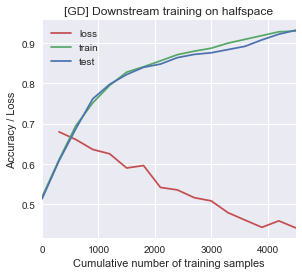

Mean essential stats across all runs:
Last downstream loss: 0.4420
Last downstream train accuracy: 0.9300
Last downstream test accuracy: 0.9320

Saving figure to: figs/comparing_transfer_rnn_halfspace


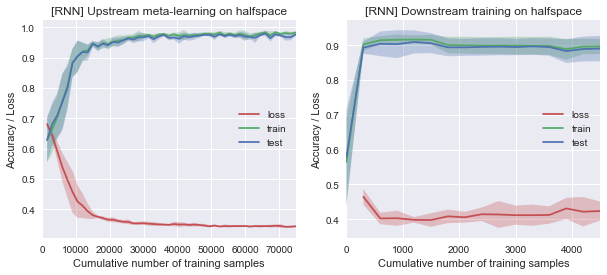

Mean essential stats across all runs:
Last upstream loss: 0.3437
Last upstream train accuracy: 0.9832
Last upstream test accuracy: 0.9768
Last downstream loss: 0.4233
Last downstream train accuracy: 0.8967
Last downstream test accuracy: 0.8904

Saving figure to: figs/comparing_transfer_prepost_halfspace


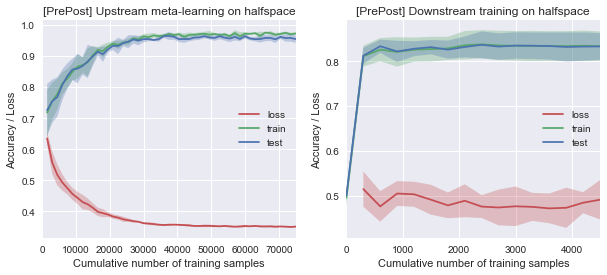

Mean essential stats across all runs:
Last upstream loss: 0.3511
Last upstream train accuracy: 0.9723
Last upstream test accuracy: 0.9544
Last downstream loss: 0.4906
Last downstream train accuracy: 0.8337
Last downstream test accuracy: 0.8332

Saving figure to: figs/comparing_transfer_prepostcount_halfspace


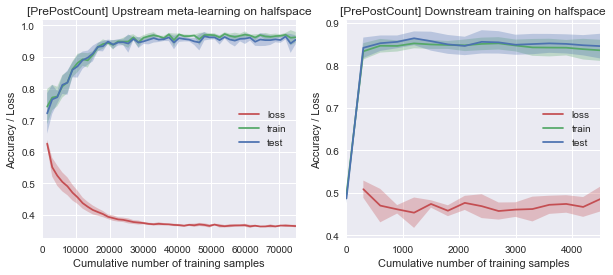

Mean essential stats across all runs:
Last upstream loss: 0.3647
Last upstream train accuracy: 0.9627
Last upstream test accuracy: 0.9548
Last downstream loss: 0.4852
Last downstream train accuracy: 0.8353
Last downstream test accuracy: 0.8452

Saving figure to: figs/comparing_transfer_prepostpercent_halfspace


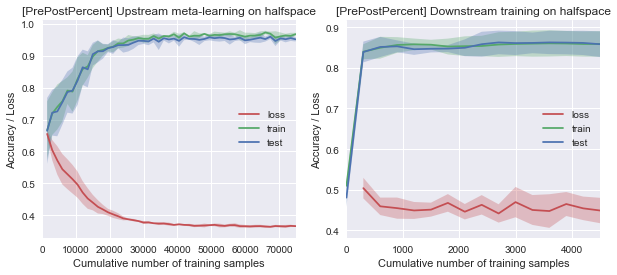

Mean essential stats across all runs:
Last upstream loss: 0.3660
Last upstream train accuracy: 0.9679
Last upstream test accuracy: 0.9516
Last downstream loss: 0.4486
Last downstream train accuracy: 0.8591
Last downstream test accuracy: 0.8584

Saving figure to: figs/comparing_transfer_postcount_halfspace


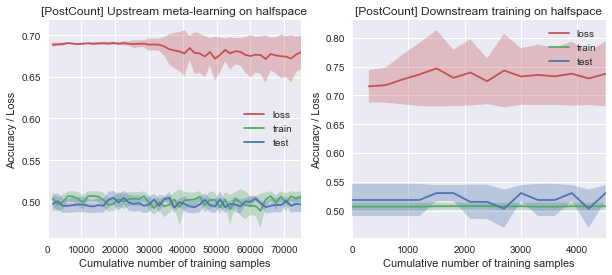

Mean essential stats across all runs:
Last upstream loss: 0.6794
Last upstream train accuracy: 0.5064
Last upstream test accuracy: 0.4968
Last downstream loss: 0.7376
Last downstream train accuracy: 0.5076
Last downstream test accuracy: 0.5304

Saving figure to: figs/comparing_transfer_annprepost_halfspace


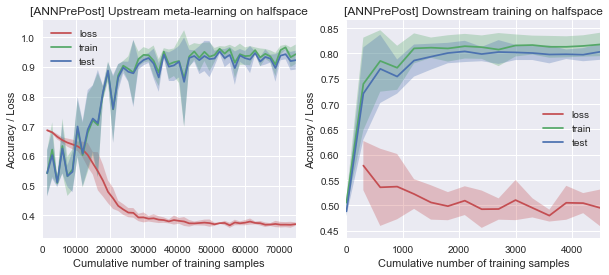

Mean essential stats across all runs:
Last upstream loss: 0.3704
Last upstream train accuracy: 0.9431
Last upstream test accuracy: 0.9232
Last downstream loss: 0.4953
Last downstream train accuracy: 0.8177
Last downstream test accuracy: 0.8032

Saving figure to: figs/comparing_transfer_annprepostall_halfspace


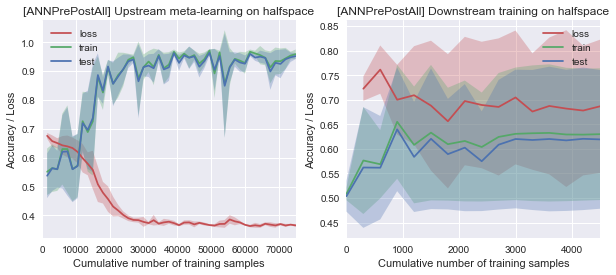

Mean essential stats across all runs:
Last upstream loss: 0.3657
Last upstream train accuracy: 0.9583
Last upstream test accuracy: 0.9516
Last downstream loss: 0.6866
Last downstream train accuracy: 0.6299
Last downstream test accuracy: 0.6192

Saving figure to: figs/comparing_transfer_annonepostall_halfspace


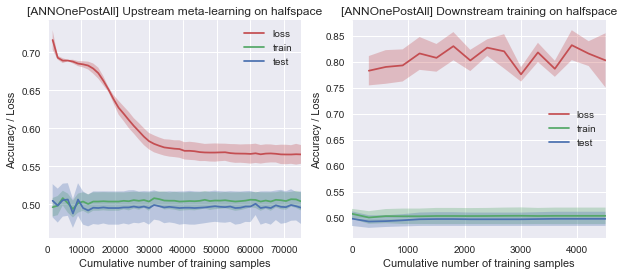

Mean essential stats across all runs:
Last upstream loss: 0.5657
Last upstream train accuracy: 0.5039
Last upstream test accuracy: 0.4956
Last downstream loss: 0.8025
Last downstream train accuracy: 0.5037
Last downstream test accuracy: 0.4980

Saving figure to: figs/comparing_transfer_annallpostall_halfspace


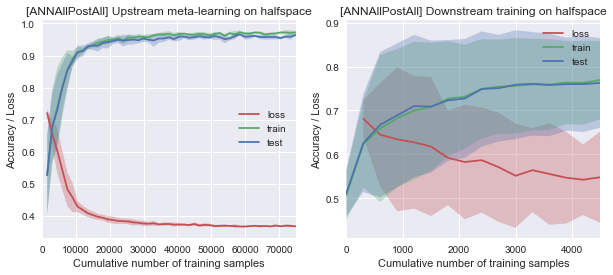

Mean essential stats across all runs:
Last upstream loss: 0.3668
Last upstream train accuracy: 0.9720
Last upstream test accuracy: 0.9640
Last downstream loss: 0.5476
Last downstream train accuracy: 0.7693
Last downstream test accuracy: 0.7628



In [9]:
# Plot all collected stats.
for tag, (stats_up, stats_down) in stats.items():    
    plot_curves(stats_up, stats_down,
                f'[{tag}] Upstream meta-learning on {dataset_up}',
                f'[{tag}] Downstream training on {dataset_down}',
                f'figs/comparing_transfer_{str.lower(tag)}_{dataset_up}')

## Compare the plasticity rules

Saving figure to: figs/comparing_transfer_table_halfspace


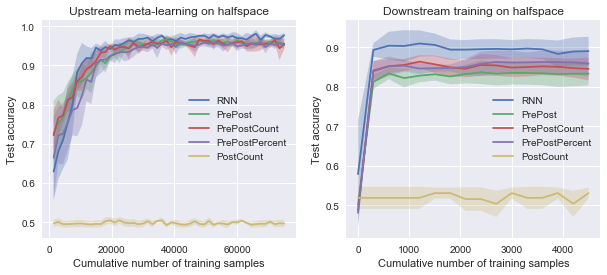

Saving figure to: figs/comparing_transfer_ann_halfspace


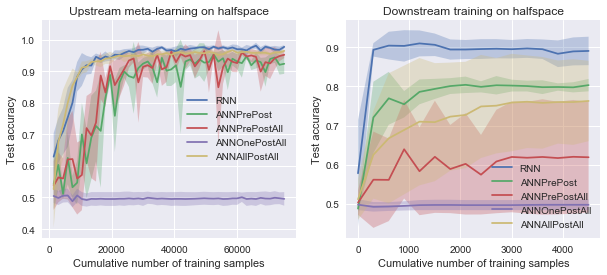

Saving figure to: figs/comparing_transfer_best_halfspace


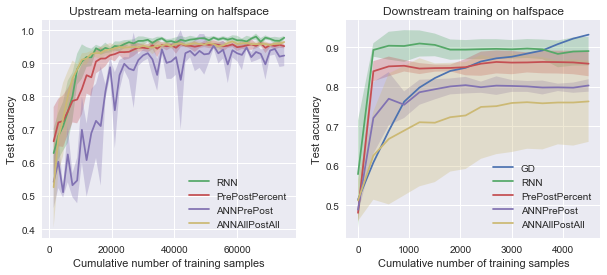

In [10]:
# Compare the rules
compare_plots = {'Table': ['RNN', 'PrePost', 'PrePostCount', 'PrePostPercent', 'PostCount'],
                 'ANN': ['RNN', 'ANNPrePost', 'ANNPrePostAll', 'ANNOnePostAll', 'ANNAllPostAll'],
                 'Best': ['GD', 'RNN', 'PrePostPercent', 'ANNPrePost', 'ANNAllPostAll']}

for plot_type, tags_to_plot in compare_plots.items():
    all_stats_up = [stats[tag][0] for tag in tags_to_plot]
    all_stats_down = [stats[tag][1] for tag in tags_to_plot]

    plot_compare_models(all_stats_up, all_stats_down, tags_to_plot,
                        f'Upstream meta-learning on {dataset_up}',
                        f'Downstream training on {dataset_down}',
                        f'figs/comparing_transfer_{str.lower(plot_type)}_{dataset_up}')

In [10]:
if 0:
    agg_stats_prepost_up = convert_multi_stats_uncertainty(stats_prepost_up)
    agg_stats_prepost_down = convert_multi_stats_uncertainty(stats_prepost_down)
    for i in range(len(stats_prepost_up)):
        plot_curves(stats_prepost_up[i], stats_prepost_down[i],
                    '[PrePost] Upstream meta-learning on ' + dataset_up,
                    '[PrePost] Downstream training on ' + dataset_down)